In [1]:
pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Sekarang bisa download
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/divaoncom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divaoncom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm
import numpy as np

# Load DataFrame
df = pd.read_csv("SteamID_and_CleanedReview.csv")

# Filter dan konversi aman
df = df.dropna(subset=['Cleaned_Review'])
df['Cleaned_Review'] = df['Cleaned_Review'].astype(str)
df = df[df['Cleaned_Review'].str.strip().astype(bool)]
df = df.reset_index(drop=True)

# Load model BERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Buat list review
reviews = df['Cleaned_Review'].tolist()

# Proses embedding
tqdm.pandas()
embeddings = model.encode(reviews, show_progress_bar=True)

# Simpan hasil embedding
emb_df = pd.DataFrame(embeddings)
emb_df.to_csv("BERT_Embeddings.csv", index=False)


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

In [18]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm
import numpy as np

# Load DataFrame
df = pd.read_csv("SteamID_and_CleanedReview.csv")

# Filter dan konversi aman
df = df.dropna(subset=['Cleaned_Review'])
df['Cleaned_Review'] = df['Cleaned_Review'].astype(str)
df = df[df['Cleaned_Review'].str.strip().astype(bool)]
df = df.reset_index(drop=True)

# Load model BERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Buat list review
reviews = df['Cleaned_Review'].tolist()

# Proses embedding
tqdm.pandas()
embeddings = model.encode(reviews, show_progress_bar=True)

# Gabungkan embeddings menjadi satu kolom sebagai string
df['Embedding'] = [','.join(map(str, emb)) for emb in embeddings]

# Simpan hasil ke CSV
df.to_csv("BERT_Embeddings_with_Reviews.csv", index=False)


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

In [19]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
from tqdm import tqdm

# Load DataFrame
df = pd.read_csv("BERT_Embeddings_with_Reviews.csv")

# Ubah kolom 'Embedding' menjadi list of float
df['Embedding_List'] = df['Embedding'].apply(lambda x: np.array([float(i) for i in x.split(',')]))

# Gabungkan menjadi array 2D
embedding_matrix = np.stack(df['Embedding_List'].values)

# Reduksi dimensi dengan UMAP ke 2 dimensi
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(embedding_matrix)

# Tambahkan hasil UMAP ke DataFrame
df['UMAP_1'] = umap_result[:, 0]
df['UMAP_2'] = umap_result[:, 1]

# Simpan hanya kolom Cleaned_Review dan UMAP ke CSV
df[['Cleaned_Review', 'UMAP_1', 'UMAP_2']].to_csv("BERT_UMAP_2D.csv", index=False)


In [6]:
pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import hdbscan
from tqdm import tqdm

# Load data hasil UMAP
df = pd.read_csv("BERT_UMAP_2D.csv")

# Siapkan data untuk clustering (dua kolom UMAP)
X = df[['UMAP_1', 'UMAP_2']].values

# Inisialisasi dan jalankan HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
cluster_labels = clusterer.fit_predict(X)

# Tambahkan label cluster ke DataFrame
df['Cluster'] = cluster_labels

# Simpan hasil akhir
df.to_csv("BERT_UMAP_HDBSCAN.csv", index=False)


# Guided BERTopic

In [34]:
from bertopic import BERTopic
import pandas as pd

# 1. Load cleaned reviews
df = pd.read_csv("PreprocessedReviews.csv")
docs = df['Cleaned_Review'].dropna().astype(str).tolist()

# 2. Inisialisasi BERTopic dengan seed topics
seed_topic_list = [
    ["mechanics","combat","controls","interaction"],
    ["bugs","lag","fps","crash","stability"],
    ["score","leaderboard","points","ranks","levels"],
    ["multiplayer","co","op","community","online"],
    ["character","npc","customization","design"],
    ["soundtrack","bgm","audio","music","melody"],
    ["plot","narrative","lore","ending","storyline"]
]
topic_model = BERTopic(seed_topic_list=seed_topic_list, calculate_probabilities=True, verbose=True)

# 3. Fit dan transform
topics, probs = topic_model.fit_transform(docs)

# 4. Tampilkan topik
for i in range(len(seed_topic_list)):
    print(f"Guided Topic {i}: {topic_model.get_topic(i)}")


2025-05-08 15:22:27,029 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

2025-05-08 15:23:18,644 - BERTopic - Embedding - Completed ✓
2025-05-08 15:23:18,663 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-08 15:23:19,208 - BERTopic - Guided - Completed ✓
2025-05-08 15:23:19,210 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-08 15:23:28,878 - BERTopic - Dimensionality - Completed ✓
2025-05-08 15:23:28,948 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-08 15:23:33,188 - BERTopic - Cluster - Completed ✓
2025-05-08 15:23:33,212 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-08 15:23:33,545 - BERTopic - Representation - Completed ✓


Guided Topic 0: [('like', 0.006478908831109672), ('time', 0.005804509477159804), ('game', 0.005693382216557264), ('get', 0.005490031982536584), ('make', 0.005488746587460638), ('feel', 0.0053339002217210295), ('charact', 0.0053329703611645456), ('cap', 0.0053036286253605605), ('thing', 0.005218714462862647), ('one', 0.005055751359284691)]
Guided Topic 1: [('card', 0.06377814511503466), ('deck', 0.04694783745420663), ('deckbuild', 0.03049305372506265), ('poker', 0.011909727069701635), ('slay', 0.011116879945743464), ('spire', 0.010848790556798717), ('unlock', 0.010417905659369881), ('fun', 0.00997266066040142), ('uniqu', 0.009852231036985048), ('build', 0.009554904962011725)]
Guided Topic 2: [('music', 0.07957208517012986), ('soundtrack', 0.042239051444729996), ('great', 0.016222317221655777), ('recommend', 0.013013101701764984), ('beauti', 0.01169227233738307), ('style', 0.011644321731744898), ('song', 0.011597709214473525), ('listen', 0.011390339386615813), ('art', 0.01095867179640840

In [36]:
results = pd.DataFrame({
    "Document": docs,
    "Topic": topics,
    # ambil probabilitas topik tertinggi untuk tiap dokumen
    "Probability": [p.max() if p is not None else None for p in probs]
})
results.to_csv("guided_docs_topics.csv", index=False)

In [37]:
# 1. Visualisasi map topik (UMAP 2D + cluster)
fig1 = topic_model.visualize_topics()
fig1.show()

# 2. Barchart: top N kata per topik
#    parameter top_n_topics bisa disesuaikan
fig2 = topic_model.visualize_barchart(top_n_topics=len(seed_topic_list), n_words=8)
fig2.show()

# 3. Visualisasi distribusi dokumen per topik
fig3 = topic_model.visualize_distribution(topics=topics, probabilities=probs, min_probability=0.05)
fig3.show()

# 4. Visualisasi hierarki topic
fig4 = topic_model.visualize_hierarchy()
fig4.show()


TypeError: BERTopic.visualize_distribution() got an unexpected keyword argument 'topics'

In [38]:
fig = topic_model.visualize_heatmap()
fig.show()

# HBDSCAN no guided topic

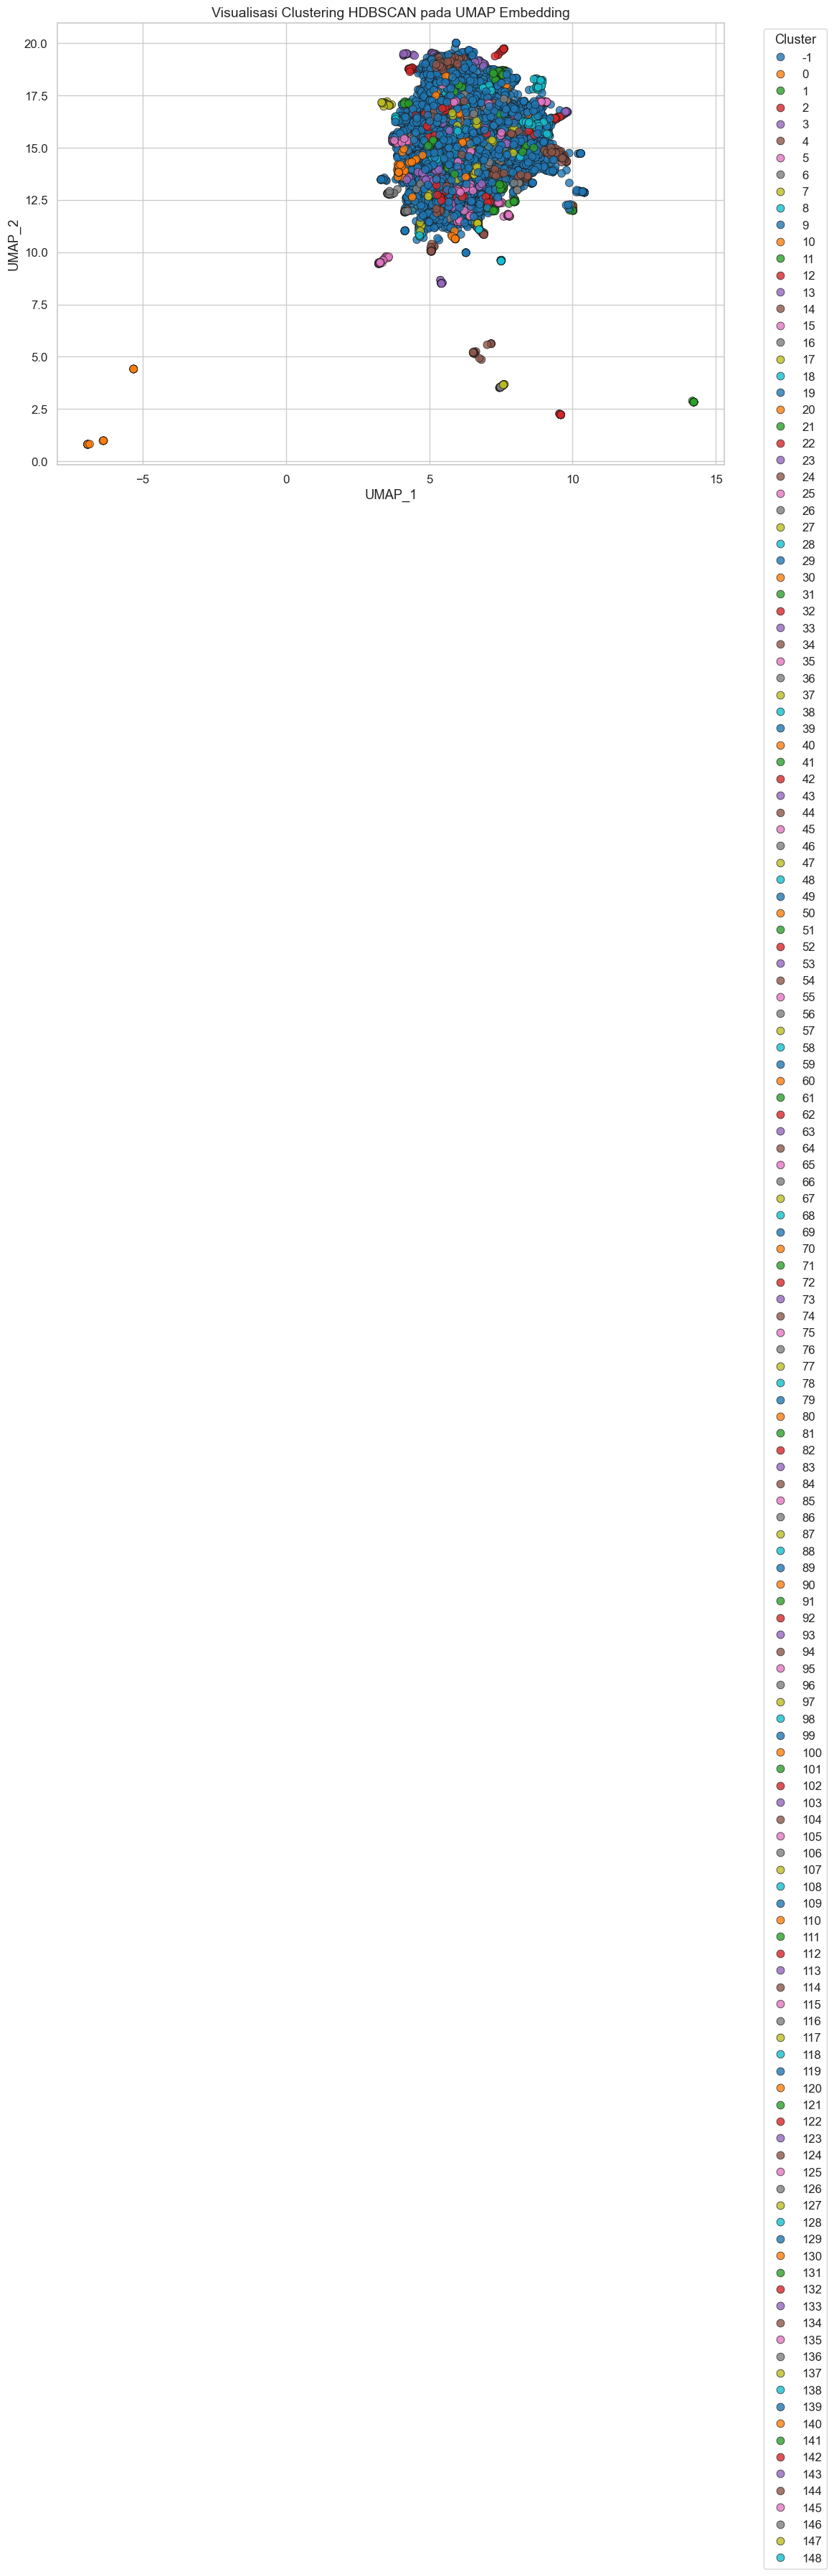

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data hasil clustering
df = pd.read_csv("BERT_UMAP_HDBSCAN.csv")

# Set style seaborn
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Ukuran gambar
plt.figure(figsize=(12, 8))

# Scatter plot UMAP dengan warna berdasarkan cluster
sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='Cluster',
    data=df,
    palette='tab10',
    legend='full',
    s=60,
    edgecolor='k',
    alpha=0.8
)

plt.title("Visualisasi Clustering HDBSCAN pada UMAP Embedding", fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load hasil clustering
df = pd.read_csv("BERT_UMAP_HDBSCAN.csv")

# Hilangkan cluster noise (-1)
df = df[df['Cluster'] != -1]

# Gabungkan semua review dalam satu cluster
cluster_docs = df.groupby('Cluster')['Cleaned_Review'].apply(lambda x: ' '.join(x)).reset_index()

# Inisialisasi TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(cluster_docs['Cleaned_Review'])

# Ambil kata-kata penting
terms = vectorizer.get_feature_names_out()
tfidf_array = tfidf_matrix.toarray()

# Buat DataFrame topik per cluster
top_n = 10  # jumlah kata teratas per cluster
top_keywords = {}

for idx, row in enumerate(tfidf_array):
    top_indices = row.argsort()[::-1][:top_n]
    top_words = [terms[i] for i in top_indices]
    top_keywords[cluster_docs['Cluster'][idx]] = top_words

# Tampilkan hasil
for cluster_id, keywords in top_keywords.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(keywords))



Cluster 0:
classic, yeah, good, ye, want, much, focu, first, fit, fix

Cluster 1:
happen, littl, zombi, fire, forward, form, forget, forc, food, follow

Cluster 2:
cool, neat, expans, found, mayb, go, much, like, first, fit

Cluster 3:
ok, guess, done, sure, that, zombi, first, fit, fix, flaw

Cluster 4:
good, buck, serious, home, creativ, expens, damn, mean, finish, big

Cluster 5:
game, great, perfect, good, content, brain, note, think, truli, aesthet

Cluster 6:
good, well, fire, found, forward, form, forget, forc, food, follow

Cluster 7:
great, job, must, stuff, made, im, well, zombi, flaw, first

Cluster 8:
minut, talk, finish, im, game, couldnt, beat, handl, fulli, ago

Cluster 9:
skin, pack, bundl, expect, dont, much, cute, great, like, stop

Cluster 10:
bundl, buy, challeng, want, map, item, much, noth, new, use

Cluster 11:
bundl, buy, bad, pretti, useless, core, worth, wasnt, music, sure

Cluster 12:
tree, game, item, fun, better, somewhat, path, fail, might, depth

Cluster

# MMR not cleaned

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Fungsi MMR
def mmr(doc_embedding, word_embeddings, words, top_n=10, diversity=0.7):
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding.reshape(1, -1))
    word_similarity = cosine_similarity(word_embeddings)
    
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(cosine_similarity(word_embeddings[candidates_idx], word_embeddings[keywords_idx]), axis=1)
        
        mmr_score = (1 - diversity) * candidate_similarities.reshape(-1) - diversity * target_similarities
        selected = candidates_idx[np.argmax(mmr_score)]
        
        keywords_idx.append(selected)
        candidates_idx.remove(selected)

    return [words[i] for i in keywords_idx]

# Load data
df = pd.read_csv("BERT_UMAP_HDBSCAN.csv")
df = df[df['Cluster'] != -1]

# Load model sekali saja
model = SentenceTransformer('all-MiniLM-L6-v2')

# Hasil akhir
mmr_results = []

# Proses tiap cluster
for cluster_id, group in df.groupby('Cluster'):
    text = ' '.join(group['Cleaned_Review'])
    
    # Candidate keywords
    vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit([text])
    keywords = vectorizer.get_feature_names_out()
    
    if len(keywords) < 10:
        continue  # Skip cluster dengan kata sangat sedikit
    
    # Embedding dokumen dan keyword
    doc_embedding = model.encode([text])[0]
    keyword_embeddings = model.encode(keywords)

    # Ambil keyword MMR
    selected_keywords = mmr(doc_embedding, keyword_embeddings, keywords, top_n=10, diversity=0.7)
    
    mmr_results.append({
        'Cluster': cluster_id,
        'MMR_Keywords': ', '.join(selected_keywords)
    })

# Simpan ke CSV
mmr_df = pd.DataFrame(mmr_results)
mmr_df.to_csv("MMR_Keywords_Per_Cluster.csv", index=False)

print("✅ MMR keyword extraction selesai dan disimpan di MMR_Keywords_Per_Cluster.csv")


✅ MMR keyword extraction selesai dan disimpan di MMR_Keywords_Per_Cluster.csv


# MMR CLEAN

In [26]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Download resource NLTK (jika belum)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# 2. Siapkan stopwords default + domain‑specific fillers
base_stop = set(stopwords.words('english'))
extra_stop = {
    'dont','know','like','ive','im','also','actually',
    'just','really','even','well','thats','could','would'
}
all_stop = list(base_stop.union(extra_stop))  # harus list untuk CountVectorizer

# 3. Definisi fungsi MMR yang safe jika kandidat kurang dari top_n
def mmr(doc_emb, word_embs, words, top_n=10, diversity=0.7):
    n_words = len(words)
    # effective number of keywords we can pick
    effective_n = min(top_n, n_words)
    # similarity tiap kata ke dokumen
    word_doc_sim = cosine_similarity(word_embs, doc_emb.reshape(1, -1)).reshape(-1)
    # pilih kata pertama: yang paling mirip dokumen
    keywords_idx = [int(np.argmax(word_doc_sim))]
    candidates = [i for i in range(n_words) if i != keywords_idx[0]]

    # iterasi untuk mengambil sisanya
    for _ in range(effective_n - 1):
        if not candidates:
            break
        # sim kandidat ke dokumen
        cand_sim = word_doc_sim[candidates]
        # sim setiap kandidat ke kata-kata yang sudah dipilih
        sim_to_selected = np.max(
            cosine_similarity(word_embs[candidates], word_embs[keywords_idx]),
            axis=1
        )
        # hitung skor MMR
        mmr_score = (1 - diversity) * cand_sim - diversity * sim_to_selected
        # pilih kandidat dengan skor tertinggi
        sel = candidates[int(np.argmax(mmr_score))]
        keywords_idx.append(sel)
        candidates.remove(sel)

    return [words[i] for i in keywords_idx]

# 4. Load data hasil clustering HDBSCAN & buang noise
df = pd.read_csv("BERT_UMAP_HDBSCAN.csv")
df = df[df['Cluster'] != -1].reset_index(drop=True)

# 5. Load SentenceTransformer sekali saja
model = SentenceTransformer('all-MiniLM-L6-v2')

# 6. Loop tiap cluster untuk ekstraksi MMR‐keywords
results = []
for cid, grp in df.groupby('Cluster'):
    text = " ".join(grp['Cleaned_Review'])

    # 6a. Ekstrak kandidat keyword (unigram) dengan stoplist diperluas
    vect = CountVectorizer(ngram_range=(1,1), stop_words=all_stop)
    kws = vect.fit([text]).get_feature_names_out().tolist()

    # 6b. POS‑filtering: hanya NOUN/ADJ
    tagged = pos_tag(word_tokenize(" ".join(kws)))
    kws = [w for w, tag in tagged if tag.startswith('NN') or tag.startswith('JJ')]

    # 6c. Skip jika terlalu sedikit keyword
    if len(kws) < 1:
        continue

    # 6d. Embedding dokumen dan kandidat keywords
    doc_emb = model.encode([text])[0]
    kw_embs = model.encode(kws)

    # 6e. Skip jika embedding gagal
    if kw_embs.shape[0] == 0:
        continue

    # 6f. Ambil top‐N keyword via MMR (maksimal sebanyak kws yang ada)
    selected = mmr(doc_emb, kw_embs, kws, top_n=10, diversity=0.7)

    results.append({
        'Cluster': cid,
        'MMR_Keywords': ", ".join(selected)
    })

# 7. Simpan hasil ke CSV
out_df = pd.DataFrame(results)
out_df.to_csv("MMR_Cleaned_Per_Cluster.csv", index=False)
print("✅ Ekstraksi MMR bersih selesai. Lihat file MMR_Cleaned_Per_Cluster.csv")

[nltk_data] Downloading package punkt to /Users/divaoncom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divaoncom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/divaoncom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


✅ Ekstraksi MMR bersih selesai. Lihat file MMR_Cleaned_Per_Cluster.csv


# Re-clustering and assigned topic

In [32]:
import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import re
import ast

# Load data keyword dari hasil MMR
df = pd.read_csv('MMR_Cleaned_Per_Cluster.csv')

# Fungsi untuk membetulkan list keyword yang rusak (tanpa tanda kutip)
def safe_parse_keywords(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        # Coba betulkan manual: tambahkan tanda kutip pada setiap kata
        fixed = re.findall(r'\w+', x)
        return fixed

# Gabungkan keyword per cluster menjadi kalimat
df['MMR_Keywords_Joined'] = df['MMR_Keywords'].astype(str).apply(lambda x: ' '.join(safe_parse_keywords(x)))

# Load model embedding BERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embedding keyword yang digabung
embeddings = model.encode(df['MMR_Keywords_Joined'].tolist(), show_progress_bar=True)

# Clustering ulang ke dalam 10 topik besar
n_topics = 10
kmeans = KMeans(n_clusters=n_topics, random_state=42)
df['Assigned_Topic'] = kmeans.fit_predict(embeddings)

# Simpan hasil akhir
output_file = "Clustered_Topics.csv"
df[['Cluster', 'MMR_Keywords', 'Assigned_Topic']].to_csv(output_file, index=False)

print(f"Berhasil disimpan di: {output_file}")


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Berhasil disimpan di: Clustered_Topics.csv


# re-clustered with BERTopic

In [27]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import ast
import re

# Load data keyword dari hasil MMR
df = pd.read_csv('MMR_Cleaned_Per_Cluster.csv')

# Fungsi untuk parsing list keyword
def safe_parse_keywords(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return re.findall(r'\w+', x)

# Bersihkan dan gabungkan keyword per cluster
df['Parsed_Keywords'] = df['MMR_Keywords'].astype(str).apply(safe_parse_keywords)
df['MMR_Keywords_Joined'] = df['Parsed_Keywords'].apply(lambda x: ' '.join(x))

# Load model embedding
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Buat dan latih model BERTopic
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, probs = topic_model.fit_transform(df['MMR_Keywords_Joined'])

# Reduksi topik menjadi 15
topic_model.reduce_topics(df['MMR_Keywords_Joined'], nr_topics=10)

# Ambil kembali topik setelah reduksi
new_topics = topic_model.transform(df['MMR_Keywords_Joined'])[0]
df['Assigned_Topic'] = new_topics

# Simpan hasil final: assigned topic dan keywords
result_df = df.groupby('Assigned_Topic')['Parsed_Keywords'].apply(lambda x: ', '.join(sum(x, []))).reset_index()
result_df.columns = ['assigned topic', 'keywords']

# Simpan ke file CSV
result_df.to_csv('Processed_Topics_15.csv', index=False)

print("✔️ BERTopic selesai! Hasil disimpan sebagai 'Processed_Topics_15.csv'")


2025-05-08 14:37:38,482 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-08 14:37:39,386 - BERTopic - Embedding - Completed ✓
2025-05-08 14:37:39,388 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-08 14:37:39,540 - BERTopic - Dimensionality - Completed ✓
2025-05-08 14:37:39,542 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-08 14:37:39,562 - BERTopic - Cluster - Completed ✓
2025-05-08 14:37:39,570 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-08 14:37:39,590 - BERTopic - Representation - Completed ✓
2025-05-08 14:37:39,603 - BERTopic - Topic reduction - Reducing number of topics
2025-05-08 14:37:39,604 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-08 14:37:39,831 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-08 14:37:39,833 - BERTopic - Dimensionality - Completed ✓
2025-05-08 14:37:39,833 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-08 14:37:39,842 - BERTopic - Cluster - Completed ✓


✔️ BERTopic selesai! Hasil disimpan sebagai 'Processed_Topics_15.csv'


# Re-cluster with mapping

In [29]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import re
import ast
from sklearn.metrics.pairwise import cosine_similarity

# Load data keyword dari hasil MMR
df = pd.read_csv('MMR_Cleaned_Per_Cluster.csv')

# Fungsi untuk membetulkan list keyword yang rusak (tanpa tanda kutip)
def safe_parse_keywords(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        fixed = re.findall(r'\w+', x)
        return fixed

# Gabungkan keyword per cluster menjadi kalimat
df['MMR_Keywords_Joined'] = df['MMR_Keywords'].astype(str).apply(lambda x: ' '.join(safe_parse_keywords(x)))

# Daftar topik dan deskripsi pendek untuk membantu pemetaan semantik
topics = {
    "Gameplay": "game mechanics, combat system, controls, interaction",
    "Performance": "bugs, lag, fps drops, crashes, stability",
    "Score & Ranking": "high score, leaderboard, points, ranks, levels",
    "Social Experience": "multiplayer, online interaction, co-op, community",
    "Character": "main character, NPC, customization, design",
    "Music": "soundtrack, BGM, audio quality, music style",
    "Story": "plot, narrative, lore, ending, storyline"
}

# Siapkan model embedding
model = SentenceTransformer('all-MiniLM-L6-v2')

# Buat embedding untuk topik
topic_names = list(topics.keys())
topic_descriptions = list(topics.values())
topic_embeddings = model.encode(topic_descriptions)

# Buat embedding untuk masing-masing keyword MMR
mmr_embeddings = model.encode(df['MMR_Keywords_Joined'].tolist(), show_progress_bar=True)

# Hitung cosine similarity untuk setiap keyword terhadap semua topik
similarities = cosine_similarity(mmr_embeddings, topic_embeddings)

# Ambil topik dengan skor similarity tertinggi
assigned_topic_labels = [topic_names[np.argmax(sim)] for sim in similarities]

# Tambahkan ke dataframe
df['Assigned_Topic'] = assigned_topic_labels

# Simpan hasil akhir
output_file = "Clustered_Topics_v2.csv"
df[['Cluster', 'MMR_Keywords', 'Assigned_Topic']].to_csv(output_file, index=False)

print(f"Berhasil disimpan di: {output_file}")


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Berhasil disimpan di: Clustered_Topics_v2.csv


In [31]:
import pandas as pd

# Membaca file CSV
df = pd.read_csv('Clustered_Topics_v2.csv')

# Membuat DataFrame baru dengan kolom 'assigned topic' dan 'keywords'
result_df = df.groupby('Assigned_Topic')['MMR_Keywords'].apply(', '.join).reset_index()

# Mengganti nama kolom sesuai dengan permintaan
result_df.columns = ['assigned topic', 'keywords']

# Menyimpan hasil ke file CSV baru
result_df.to_csv('Labeled_Topics_v2.csv', index=False)

print("File CSV berhasil dibuat!")

File CSV berhasil dibuat!


In [3]:
import pandas as pd

# 1. Baca file hasil clustering
df = pd.read_csv("Clustered_Topics.csv")

# 2. Definisikan mapping Assigned_Topic → Topic_Label
topic_label_map = {
    0: "Franchise / Series Discussion",
    1: "Gameplay Improvements",
    2: "Story / Narrative Quality",
    3: "Gameplay Mechanics",
    4: "Sound / Music",
    5: "Content / Mode Variety",
    6: "Characters / Protagonists",
    7: "Performance / Technical Issues",
    8: "Overall Reception / Praise",
    9: "Game Modes / Expansions",
    # Jika ada Assigned_Topic di luar 0–9, bisa ditambahkan di sini
}

# 3. Tambahkan kolom Topic_Label
df["Topic_Label"] = df["Assigned_Topic"].map(topic_label_map).fillna("Other")

# 4. Simpan ke CSV baru
output_file = "Clustered_Topics_Labeled.csv"
df.to_csv(output_file, index=False)

print(f"✅ File dengan label topic disimpan sebagai: {output_file}")


✅ File dengan label topic disimpan sebagai: Clustered_Topics_Labeled.csv


In [4]:
import pandas as pd

# 1. Baca file yang sudah berisi kolom Topic_Label
df = pd.read_csv("Clustered_Topics_Labeled.csv")

# 2. Group by Topic_Label dan gabungkan semua MMR_Keywords dalam satu string per label
agg = (
    df
    .groupby("Topic_Label")["MMR_Keywords"]
    .apply(lambda kws: "; ".join(kws))
    .reset_index()
)
agg.columns = ["Topic_Label", "Keywords"]

# 3. Simpan ke CSV baru
output_file = "Topic_Label_Keywords.csv"
agg.to_csv(output_file, index=False)

print(f"✅ File baru tersimpan sebagai: {output_file}")


✅ File baru tersimpan sebagai: Topic_Label_Keywords.csv
